In [8]:
%reset

In [9]:
import importlib

for module in ['kooplearn', 'datasets', 'matplotlib', 'ml-confs']: # !! Add here any additional module that you need to install on top of kooplearn
    try:
        importlib.import_module(module)
    except ImportError:
        if module == 'kooplearn':
            module = 'kooplearn[full]'
        %pip install -q {module}

import matplotlib.pyplot as plt
import torch
import numpy as np

from src import OU_process
import ml_confs
from pathlib import Path
from tqdm import tqdm

from sklearn.gaussian_process.kernels import RBF

zsh:1: no matches found: kooplearn[full]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
configs = ml_confs.from_file("configs.yaml")
data_points = OU_process.sample(configs.n_train_points + configs.n_val_points + configs.n_test_points, num_trajectories= configs.n_repits)
print(data_points.shape)

(50000, 1)


In [11]:
print(data_points.dtype)

float16


In [12]:
def make_block_matrices(matrix, tau):
    n = matrix.shape[0]
    assert n % tau == 0, "Matrix dimensions must be divisible by tau"

    n_blocks = n // tau
    blocks = matrix.reshape(n_blocks, tau, n_blocks, tau)
    block_matrix_result = blocks.transpose(0, 2, 1, 3)
    
    return block_matrix_result

def biased_covariance_estimator(cov_mtx, tau):
    n = cov_mtx.shape[0]
    block_cov_matrix = make_block_matrices(cov_mtx,tau)
    diag_blocks = torch.diagonal(torch.from_numpy(block_cov_matrix), offset=0, dim1=0, dim2=1)
    return (torch.sum(torch.pow(diag_blocks,2))/(n*tau)).item()

def unbiased_covariance_estimator(cov_mtx, tau):
    n = cov_mtx.shape[0]
    m = n / (2*tau)
    block_cov_matrix = make_block_matrices(cov_mtx,tau)
    block_cov_matrix = torch.from_numpy(block_cov_matrix)

    diag_blocks = torch.diagonal(block_cov_matrix, offset=0, dim1=0, dim2=1)
    plus_term = torch.sum(torch.pow(diag_blocks,2))
    minus_term = 0
    for signed in [1,-1]:
        for i in range(2,n, 2):
            diag_blocks = torch.diagonal(block_cov_matrix, offset=i*signed, dim1=0, dim2=1)
            minus_term += torch.sum(torch.pow(diag_blocks,2)) 
    
    # print(plus_term, minus_term)
    sum = plus_term - (minus_term / (m-1))
    if sum < 0:
        return 0.0

    return (sum /(n*tau)).item()

In [13]:
Ns = [100,200,500,1000,2000,5000,10000,20000,50000]
n_0 = len(Ns)
data_bound_biased_cov_est = np.empty((n_0, configs.n_repits))
data_bound_unbiased_cov_est = np.empty((n_0, configs.n_repits))
pess_bound = np.empty((n_0, configs.n_repits))
n = configs.n_train_points
delta = 0.05
length_scale= 0.5
gauss_kernel = RBF(length_scale=length_scale)
c_h = 1
L = 2 * c_h
sigma = c_h

for i in range(configs.n_repits):    
    X = data_points[0:configs.n_train_points][:,i]
    X = X.reshape(X.shape[0], -1)
    print(X.shape)
    kernel_Matrix = gauss_kernel(X, X)
    print(kernel_Matrix.shape)
    print("hoooooof")
    for j in tqdm(range(len(Ns))):
        n = Ns[j]
        for tau in range(1,n):
            if delta >= 2*(n/(2*tau) - 1)*np.exp(-(np.exp(1) -  1)/np.exp(1)*tau) and (n / tau) % 2 == 0 :
                min_tau = tau
                break
        
        tau = min_tau 
        beta_coeff = np.exp((1/np.exp(1) - 1) *tau)
        m = n / (2*tau)
        # print(tau, delta - 2*(m-1)*beta_coeff)

        l_tau = np.log(4/(delta - 2*(m-1)*beta_coeff))
        
        pess_bound[j][i] = (((2 * L ) / m)  + (2 * sigma)/np.sqrt(m))* l_tau
        
        cov_biased = biased_covariance_estimator(kernel_Matrix[0:n,0:n], tau= tau)
        data_bound_biased_cov_est[j][i] = ((32*c_h)/(3*m))*l_tau + np.sqrt(((2*l_tau + 1)*cov_biased)/m)
        
        cov_unbiased = unbiased_covariance_estimator(kernel_Matrix[0:n,0:n], tau= tau)
        print(cov_biased, cov_unbiased)
        data_bound_unbiased_cov_est[j][i] = ((26*c_h)/(m))*l_tau + np.sqrt(((2*l_tau + 1)*cov_unbiased)/m)

with open('pess_bound.npy', 'wb') as f:
    np.save(f, pess_bound)

with open('data_bound_biased_cov_est.npy', 'wb') as f:
    np.save(f, data_bound_biased_cov_est)

with open('data_bound_biased_cov_est.npy', 'wb') as f:
    np.save(f, data_bound_biased_cov_est)

pess_bound_mean = np.mean(pess_bound, axis=-1)
pess_bound_std = np.std(pess_bound, axis=-1)

data_bound_biased_est_mean = np.mean(data_bound_biased_cov_est, axis=-1)
data_bound_biased_est_std = np.std(data_bound_biased_cov_est, axis=-1)

data_bound_unbiased_est_mean = np.mean(data_bound_unbiased_cov_est, axis=-1)
data_bound_unbiased_est_std = np.std(data_bound_biased_cov_est, axis=-1)

(50000, 1)


: 

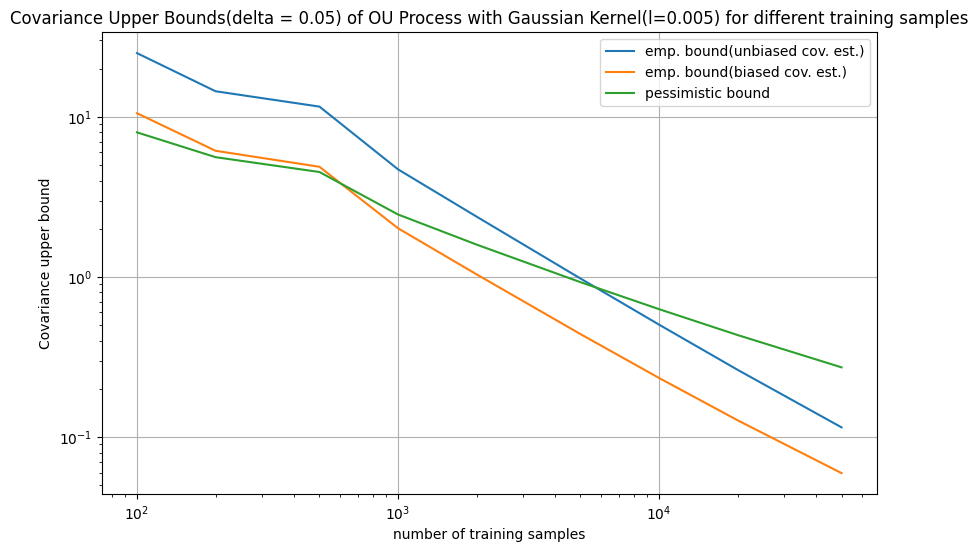

In [ ]:
# Plot
plt.figure(figsize=(10, 6))

plt.loglog(Ns, data_bound_unbiased_est_mean, label="emp. bound(unbiased cov. est.)")
plt.fill_between(Ns, data_bound_unbiased_est_mean - data_bound_unbiased_est_std, data_bound_unbiased_est_mean + data_bound_unbiased_est_std, alpha=0.2)

plt.loglog(Ns, data_bound_biased_est_mean, label="emp. bound(biased cov. est.)")
plt.fill_between(Ns, data_bound_biased_est_mean - data_bound_biased_est_std, data_bound_biased_est_mean + data_bound_biased_est_std, alpha=0.2)

plt.loglog(Ns, pess_bound_mean, label="pessimistic bound")
plt.fill_between(Ns, pess_bound_mean - pess_bound_std, pess_bound_mean + pess_bound_std, alpha=0.2)

plt.xlabel("number of training samples")
plt.ylabel("Covariance upper bound")
plt.title(f"Covariance Upper Bounds(delta = {delta}) of OU Process with Gaussian Kernel(l={length_scale}) for different training samples")
plt.legend()
plt.grid(True)
plt.savefig("OU_Exp.svg", format="svg", dpi = 300)


In [ ]:
pip install pykeops

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

from pykeops.numpy import KernelSolve
import pykeops.config

In [ ]:
X = data_points[0:configs.n_train_points][:,i]
X = X.reshape(X.shape[0], -1)
print(X.shape)
kernel_Matrix = gauss_kernel(X, X)
print(kernel_Matrix.shape)
print("hoooooof")